# <h1><center><b> 🚦 Traffic Light Detection and Classification Using SSD, Inception🚦 </b></center></h1>



<img src='https://miovision.com/wp-content/uploads/2024/06/unnamed.png'>

---------------------------------

## **🚦 Hello everyone! After a long time, I’m publishing a new notebook. It’s all about my exploration of traffic light detection and recognition using TensorFlow (Inception model).** 

## **🚦Currently, I am learning and exploring self-driving car perception functionality. Recently, I focused on exploring the specific functionality of traffic light detection and recognition.**

--------------------------
## **Block diagram:**

<img src='https://www.researchgate.net/publication/312304505/figure/fig1/AS:690522687537153@1541644846571/The-typical-architecture-of-traffic-light-detection.jpg'>

🚦 Data Set: Opensource

- LISA Traffic Light Dataset - 🚀 It has more than 44 minutes of annotated traffic light data.

- Cropped lisa traffic light dataset


# **1. Import Necessary Library**

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import sys
from pathlib import Path
from PIL import Image

#evalutation
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import sklearn.metrics as metrics

#DL
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image

# This is needed to display the images.
%matplotlib inline

# 2. **Detect the traffic light using SSD mobilnetv1 model**

<img src='https://seongkyun.github.io/assets/post_img/study/2019-04-24-ssds_architecture/mobilenet-ssd.jpg'>

---------------------------------------------

### **WHAT, WHY SSD**

- Lightweight Architecture: Combines the SSD framework with MobileNet v1, making it highly efficient with fewer parameters.

- Real-Time Performance: Designed for fast inference speeds, even on devices with limited computational power.

- Edge Device Compatibility: Ideal for mobile phones, Raspberry Pi, and embedded systems due to its low memory and processing requirements.

- Pre-Trained Models: Easily available pre-trained models on datasets like COCO, enabling faster deployment and fine-tuning for custom use cases.

- Balanced Accuracy: Offers reasonable detection accuracy while maintaining a tradeoff between performance and computational efficiency.

- TensorFlow Lite Support: Optimized for TensorFlow Lite, making it suitable for deployment on mobile and IoT platforms with hardware accelerators.


In [51]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
model_path = "./"
PATH_TO_CKPT = model_path + MODEL_NAME + '/frozen_inference_graph.pb'


def download_model():
    import six.moves.urllib as urllib
    import tarfile

    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

## **2.1. Detection all functionality: Load the image, detect the traffic light**

In [52]:
def load_graph():
    if not os.path.exists(PATH_TO_CKPT):
        download_model()

    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return detection_graph

def select_boxes(boxes, classes, scores, score_threshold=0, target_class=10):
    """

    :param boxes:
    :param classes:
    :param scores:
    :param target_class: default traffic light id in COCO dataset is 10
    :return:
    """

    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)

    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)

    return sq_boxes[sel_id]

class TLClassifier(object):
    def __init__(self):

        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.Session(graph=self.detection_graph)

        # run the first session to "warm up"
        dummy_image = np.zeros((100, 100, 3))
        self.detect_multi_object(dummy_image,0.1)
        self.traffic_light_box = None
        self.classified_index = 0

    def extract_graph_components(self):
        # Definite input and output Tensors for detection_graph
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')
    
    def detect_multi_object(self, image_np, score_threshold):
        """
        Return detection boxes in a image

        :param image_np:
        :param score_threshold:
        :return:
        """

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.

        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})

        sel_boxes = select_boxes(boxes=boxes, classes=classes, scores=scores,
                                 score_threshold=score_threshold, target_class=10)

        return sel_boxes
        
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    (left, right, top, bottom) = (sel_box[1] * im_width, sel_box[3] * im_width,
                                  sel_box[0] * im_height, sel_box[2] * im_height)
    cropped_image = image_np[int(top):int(bottom), int(left):int(right), :]
    return cropped_image


In [53]:
tlc=TLClassifier()

## **2.2. Testing the model in image**

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


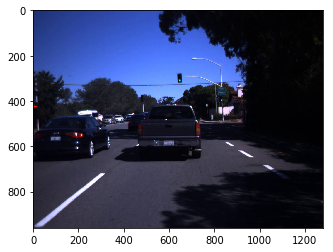

In [54]:
%time
test_file = "/kaggle/input/lisa-traffic-light-dataset/sample-dayClip6/sample-dayClip6/frames/dayClip6--00332.jpg"
im = Image.open(test_file)
image_np = np.asarray(im)
plt.imshow(image_np)

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11 µs


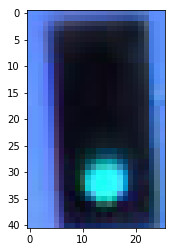

In [55]:
%time
boxes=tlc.detect_multi_object(image_np,score_threshold=0.2)
if len(boxes)>0:
    cropped_image=crop_roi_image(image_np,boxes[0])
    plt.imshow(cropped_image)
    immmm = Image.fromarray(cropped_image)
    immmm.save('./temp.jpg')
else:
    print('No traffic light was detected or light is off')

# 3. **Classification the traffic light using Inception model**

<img src='https://wngaw.github.io/images/inception_v3_architecture.png'>

------------------------------------------

**WHAT, WHY Inception model:**

- Definition: The Inception model is a deep convolutional neural network developed by Google, first introduced as GoogLeNet (Inception v1) in 2014.
- Core Concept: Uses Inception modules, which perform multi-scale convolutions (1x1, 3x3, 5x5) in parallel, capturing diverse features at each layer.
- Dimensionality Reduction: Incorporates 1x1 convolutions to reduce computational cost while preserving feature richness.
- Scalability: Evolved into Inception v2, v3, v4, and Inception-ResNet to balance accuracy and efficiency.
- Target: Designed primarily for high-performance image classification tasks, including ImageNet.

------------------------------------------------------
**Indetail info:**

- Modular Design: Inception uses multi-scale convolutions in a single layer, capturing fine and coarse features simultaneously.

- High Efficiency: Factorized convolutions reduce computation without sacrificing performance, making it efficient for large datasets.

- Scalability: Different versions (v1, v2, v3, v4, and Inception-ResNet) cater to varying accuracy and resource requirements.

- Inception v3: Best for a balance of accuracy and speed, widely used for classification and transfer learning tasks.

- Inception-ResNet: Combines Inception’s multi-scale approach with ResNet’s skip connections, achieving state-of-the-art accuracy.

- Pre-Trained Models: Easily available pre-trained weights on popular datasets like ImageNet, enabling quick adaptation to custom tasks.


## **3.2. Transfer Learning of Inception model with imagenet**

In [56]:
IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = Flatten()(inception.output)

In [57]:
train_path = '../input/cropped-lisa-traffic-light-dataset/cropped_lisa_1/train_1'
valid_path = '../input/cropped-lisa-traffic-light-dataset/cropped_lisa_1/val_1'

folders = glob(train_path+'/*')

In [58]:
prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

## **3.3. Data augmentation**

In [59]:
#data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = False)

val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 32797 images belonging to 7 classes.
Found 3737 images belonging to 7 classes.


In [60]:
print(training_set.class_indices)

{'go': 0, 'goForward': 1, 'goLeft': 2, 'stop': 3, 'stopLeft': 4, 'warning': 5, 'warningLeft': 6}


## **3.4. Train the model**

In [61]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=2,
  steps_per_epoch=len(training_set),
  validation_steps=len(val_set)
)

Epoch 1/2
1025/1025 [==============================] - 381s 371ms/step - loss: 6.4349 - acc: 0.7153 - val_loss: 8.4799 - val_acc: 0.7383
Epoch 2/2
1025/1025 [==============================] - 386s 376ms/step - loss: 4.0384 - acc: 0.8137 - val_loss: 10.6107 - val_acc: 0.3872


## **3.5. Evaluating the model**

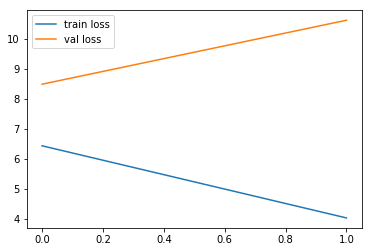

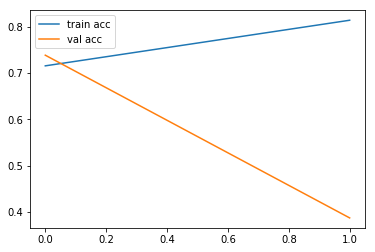

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [63]:
batch_size = 32
def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,7))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

val_labels, val_preds = true_and_predicted_labels(val_set)

In [64]:
a = val_preds
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

In [65]:
print(classification_report(val_labels, a))

              precision    recall  f1-score   support

           0       0.87      0.67      0.76      1372
           1       0.00      0.00      0.00        21
           2       0.06      0.18      0.09       109
           3       0.79      0.08      0.15      1777
           4       0.15      0.84      0.26       345
           5       0.24      0.57      0.34       108
           6       0.00      0.00      0.00         5

   micro avg       0.39      0.39      0.39      3737
   macro avg       0.30      0.34      0.23      3737
weighted avg       0.72      0.39      0.39      3737
 samples avg       0.39      0.39      0.39      3737



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
print(confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1)))

[[ 924    0  303    4  135    6    0]
 [   6    0   13    0    2    0    0]
 [  64    0   20    0   23    2    0]
 [  50    0    5  150 1396  176    0]
 [   4    0    3   35  291   12    0]
 [  15    0    2    0   29   62    0]
 [   2    0    0    0    3    0    0]]


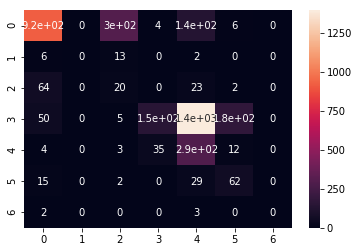

In [67]:
import seaborn as sns
cf_matrix = confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1))
sns.heatmap(cf_matrix, annot=True)

# **4. Test the model**

In [68]:
test_img = './temp.jpg'

image = tf.keras.preprocessing.image.load_img(test_img)
im1 = image.resize((224, 224), Image.ANTIALIAS)
input_arr = tf.keras.preprocessing.image.img_to_array(im1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)

In [69]:
all_class_names = training_set.class_indices
all_class_names

{'go': 0,
 'goForward': 1,
 'goLeft': 2,
 'stop': 3,
 'stopLeft': 4,
 'warning': 5,
 'warningLeft': 6}

go


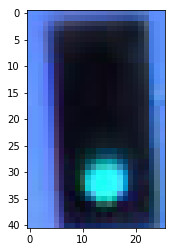

In [70]:
pos_pred = predictions.argmax() 
key_list = list(all_class_names.keys())
val_list = list(all_class_names.values())
position = val_list.index(pos_pred)
print(key_list[position])
plt.imshow(cropped_image)

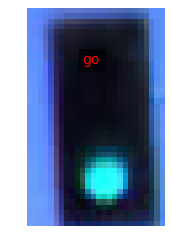

In [71]:
import matplotlib.pyplot as plt

# Assuming pos_pred, key_list, val_list, position, and cropped_image are defined
pos_pred = predictions.argmax() 
key_list = list(all_class_names.keys())
val_list = list(all_class_names.values())
position = val_list.index(pos_pred)

# Get the text label
text_label = key_list[position]

# Plot the cropped image
plt.imshow(cropped_image)
plt.axis('off')  # Optional: turn off axes for a cleaner look

# Add text to the image
plt.text(
    x=10, y=10,  # Coordinates (adjust as needed)
    s=text_label,  # Text label
    color='red',  # Text color
    fontsize=14,  # Text size
    bbox=dict(facecolor='black', alpha=0.5)  # Background for text
)

# Show the image
plt.show()


# **Notes:**

If you want improve the accuracy of detection and classification

- increase the epochs
- Hyperparameter tuning: learning rate
- change model
- Add more layers
- prunning and quantization the model, if you go to use real time

## **Full credit: https://www.kaggle.com/code/chandanakuntala/detection-classification-of-traffic-lights**

## **⭐️⭐️⭐️Thankyou for visiting Guys, if you like the notebook upvote!!!⭐️⭐️⭐️¶**